# 1: Import and preparation

In [5]:
import pandas as pd

# Load the datasets
true_news = pd.read_csv("True.csv")
fake_news = pd.read_csv("Fake.csv")

# Add labels to the data (1 for true news, 0 for fake news)
true_news["label"] = 1
fake_news["label"] = 0

# Combine the datasets
data = pd.concat([true_news, fake_news], ignore_index=True)

# Preprocess and clean the text data
# You can use libraries like NLTK or spaCy for text preprocessing
data.drop(columns = ['date'], inplace = True)
data['title+text'] = data['title'] + ' ' + data['text']
data.head()

,title,text,subject,label,title+text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


# 2: Data Cleaning

In [17]:
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
nltk.download("stopwords")
stop_words = stopwords.words('english')
stop_words.extend(['re', 'edu'])
# Removing Stopwords And Remove Words With 2 Or Less Characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

data['cleaned'] = data['title+text'].apply(preprocess)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
list_of_words = []
for i in data.clean:
    for j in i:
        list_of_words.append(j)
total_words = len(list(set(list_of_words)))
data['clean_joined'] = data['cleaned'].apply(lambda x: " ".join(x))
data

,title,text,subject,label,title+text,clean,cleaned,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...","[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...","[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...","[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...","[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...","[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...","[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...","[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...","[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


# 3: Visualization

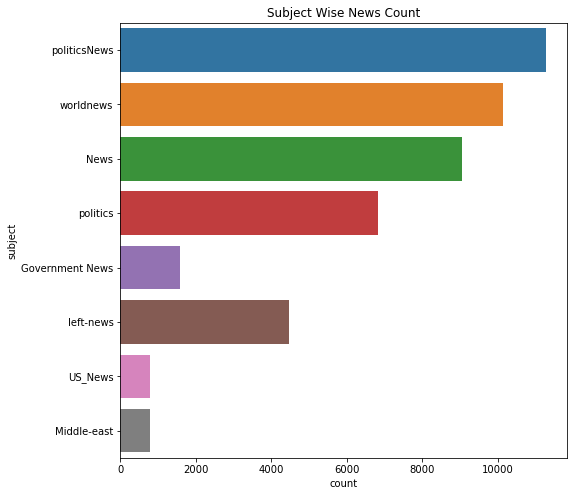

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 8))
plt.title("Subject Wise News Count")
sns.countplot(y = "subject", data = data)
plt.show()

# 4: Tokenization And Padding

In [28]:
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train, x_test, y_train, y_test = train_test_split(data.clean_joined, data.label, test_size = 0.2)

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

# 5: Building And Training The Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
import numpy as np

model = Sequential()

# Embeddidng layer
model.add(Embedding(total_words, output_dim = 128))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

y_train = np.asarray(y_train)
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

Epoch 1/5
506/506 [==============================] - 114s 215ms/step - loss: 0.0390 - acc: 0.9833 - val_loss: 0.0061 - val_acc: 0.9992
Epoch 2/5
506/506 [==============================] - 112s 221ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0058 - val_acc: 0.9992
Epoch 3/5
506/506 [==============================] - 112s 221ms/step - loss: 3.4099e-04 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 0.9986
Epoch 4/5
506/506 [==============================] - 110s 217ms/step - loss: 6.9831e-05 - acc: 1.0000 - val_loss: 0.0098 - val_acc: 0.9989
Epoch 5/5
506/506 [==============================] - 106s 210ms/step - loss: 1.9526e-06 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 0.9983


In [ ]:
pred = model.predict(padded_test)

prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

# 6: Finding topics that indicate fake news (unfinished)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the text data
X = vectorizer.fit_transform(data["text"]).toarray()
y = data["label"].values

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and test sets (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets (75/25)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Define a list of possible C values to try
C_values = np.logspace(-3, 3, 7)

# Initialize the best accuracy and best C value
best_accuracy = 0
best_C = None

for C in C_values:
    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_C = C

    print(f"C: {C}, Validation accuracy: {val_accuracy}")

print(f"Best C: {best_C}, Best validation accuracy: {best_accuracy}")

# Train the model with the best hyperparameters
best_model = LogisticRegression(max_iter=1000, C=best_C)
best_model.fit(X_trainval, y_trainval)

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


C: 0.001, Validation accuracy: 0.7179287305122495
C: 0.01, Validation accuracy: 0.9467706013363029
C: 0.1, Validation accuracy: 0.9714922048997773
C: 1.0, Validation accuracy: 0.9860801781737194
C: 10.0, Validation accuracy: 0.9913140311804008
C: 100.0, Validation accuracy: 0.9923162583518931
C: 1000.0, Validation accuracy: 0.9924276169265034
Best C: 1000.0, Best validation accuracy: 0.9924276169265034
Test accuracy: 0.9934298440979955


In [34]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Investigate feature importance
feature_importance = pd.DataFrame({"feature": vectorizer.get_feature_names_out(), "importance": model.coef_[0]})
feature_importance = feature_importance.sort_values("importance", ascending=False)

print("Top features for fake news:")
print(feature_importance.head(10))

print("Top features for true news:")
print(feature_importance.tail(10))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Top features for fake news:
         feature  importance
3861     reuters  160.023966
3967        said   37.124771
3089         nov   24.677330
4870  washington   18.350821
4677     tuesday   17.525473
3803  republican   16.835580
951      comment   14.657749
1518         edt   14.485633
4895   wednesday   13.871571
1630         est   13.207476
Top features for true news:
       feature  importance
4874     watch  -18.397551
939        com  -19.081990
4061       sen  -19.592439
3778       rep  -20.666998
2514      just  -21.281926
1980     getty  -22.234928
2009       gop  -27.196642
1776  featured  -27.407992
2265     image  -27.532508
3658      read  -36.843219


In [36]:
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
